# Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Bidirectional, LSTM, SimpleRNN, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

2024-06-13 18:50:11.252292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 18:50:11.381142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data

In [3]:
true = pd.read_csv('True.csv')
true.sample(n=5)

,title,text,subject,date
3443,German industry says Trump's climate pact pull...,BERLIN (Reuters) - German industry association...,politicsNews,"June 2, 2017"
13054,Britain needs 'new paradigm' for financial ser...,LONDON (Reuters) - Britain will need a new pa...,worldnews,"December 5, 2017"
4521,Trump presses China on North Korea ahead of Xi...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 2, 2017"
16731,UK PM May says she is 'ambitious and positive'...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 23, 2017"
17078,Colombia's FARC say six ex-members murdered in...,BOGOTA (Reuters) - Armed gunmen this week kill...,worldnews,"October 19, 2017"


In [4]:
fake = pd.read_csv('Fake.csv')
fake.sample(n=5)

,title,text,subject,date
22719,ABC News Suspend Anchor Brian Ross Over Fake N...,After 18 months of rampant speculation over Tr...,Middle-east,"December 5, 2017"
18511,“BALONEY!” CNN Anchor Slammed By Weather Chann...,"John Coleman, Founder, The Weather Channel, ap...",left-news,"Jun 10, 2017"
23082,PC TYRANNY: University of Oregon Rules That Pr...,21st Century Wire says By cow-towing to studen...,Middle-east,"December 30, 2016"
4147,Here’s The Master List Of Reasons Why Trump W...,We know Trump is a sexual predator. We know he...,News,"October 18, 2016"
11578,THIS IS OKAY? Loudmouth Entertainer Who Got Mi...,Nothing is off-limits for Leslie Jones stand-...,politics,"Feb 25, 2017"


# Data Preparation

In [5]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [7]:
# Unique subject values
print(f'True news unique subjects: {true.subject.unique()}')
print(f'Fake news unique subjects: {fake.subject.unique()}')

True news unique subjects: ['politicsNews' 'worldnews']
Fake news unique subjects: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [8]:
# No need for Subject and Date columns
true = true.drop(['subject', 'date'], axis=1)
fake = fake.drop(['subject', 'date'], axis=1)

In [9]:
# Labeling
labels_true = np.ones(len(true))
labels_fake = np.zeros(len(fake))

labels = np.concatenate((labels_true, labels_fake), axis=0)

In [10]:
labeler = lambda label: 'Real' if label == 1.0 else 'Fake'

In [11]:
# Concatenating data
data = pd.concat([true, fake])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [12]:
# Longest Title and Text
max_title = 0
max_text = 0

for title, text in np.array(data.iloc[::, :2]):
    if len(title.split()) > max_title: 
        max_title = len(title.split())
    if len(text.split()) > max_text: 
        max_text = len(text.split())

print(f'Longest Title: {max_title}')
print(f'Longest Text: {max_text}')

Longest Title: 42
Longest Text: 8135


In [13]:
# Tokenizer
VOCAB_SIZE = 100000
tokenizer = TextVectorization(max_tokens=VOCAB_SIZE)
tokenizer.adapt(pd.concat([data['title'], data['text']], axis=0))

2024-06-13 18:50:20.428381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [14]:
# Tokenizing title and  text columns
TITLE_SIZE = 40
TEXT_SIZE = 8000

def tokenize(string: str, padding: int) -> list[int]:
    tokens = tokenizer(string).numpy().tolist()

    if len(tokens) < padding:
        tokens.extend([0] * (padding - len(tokens)))
        return tokens
    
    if len(tokens) > padding:
        return tokens[:padding]

    return tokens
    
tokenized_title = np.array([tokenize(title, TITLE_SIZE) for title in data['title'].to_numpy()])
tokenized_text = np.array([tokenize(text, TEXT_SIZE) for text in data['text'].to_numpy()])

In [15]:
# First news sample tokenized
print('Title: \n' + data['title'].to_numpy()[0])
print(tokenized_title[0])
print('\nText: \n' + data['text'].to_numpy()[0])
print(tokenized_text[0])
print(f'\nLabel: {labels[0]} ({labeler(labels[0])})')

Title: 
As U.S. budget fight looms, Republicans flip their fiscal script
[   19    31   474   479 10908   139  8288    41  1379  5187     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]

Text: 
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the

# Dataset 

In [16]:
# Creating tensorflow dataset
dataset = Dataset.from_tensor_slices(((tokenized_title, tokenized_text), labels))
dataset = dataset.cache()
dataset = dataset.shuffle(50000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(16)

In [17]:
print(f'Number of batches: {len(dataset)}')

Number of batches: 1404


In [18]:
# Splitting dataset
train = dataset.take(982)  # ~70%
valid = dataset.skip(982).take(280)  # ~20%
test = dataset.skip(1262).take(142)  # ~10%

# Model

In [19]:
# Title layers
title_input = Input(shape=(TITLE_SIZE, ))
title_embeding = Embedding(input_dim=(VOCAB_SIZE + 1), output_dim=128)
title_lstm = Bidirectional(LSTM(64, return_sequences=True))
title_rnn = Bidirectional(SimpleRNN(64))
title_dense = Dense(128, activation='relu')

# Text layers
text_input = Input(shape=(TEXT_SIZE, ))
text_embeding = Embedding(input_dim=(VOCAB_SIZE + 1), output_dim=128)
text_lstm = Bidirectional(LSTM(64, return_sequences=True))
text_rnn = Bidirectional(SimpleRNN(64))
text_dense = Dense(128, activation='relu')

# Common layers
concatenate = Concatenate()
dense1 = Dense(256, activation='relu')
dense2 = Dense(128, activation='relu')
dense3 = Dense(1, activation='sigmoid')

In [20]:
# Model
title_layers = title_dense(title_rnn(title_lstm(title_embeding(title_input))))
text_layers = text_dense(text_rnn(text_lstm(text_embeding(text_input))))
output = dense3(dense2(dense1(concatenate([title_layers, text_layers ]))))

model = Model(inputs=[title_input, text_input], outputs=output)

In [21]:
# Compiling
optimizer = Adam()
loss = BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'precision', 'recall'])

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 8000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 128)   │ 12,800,128 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 8000, 128) │ 12,800,128 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 40, 128)   │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 8000, 128) │     98,816 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     24,704 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     24,704 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,979,137 (99.10 MB)

 Trainable params: 25,979,137 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Trainig
history = model.fit(train, epochs=3, validation_data=valid)

Epoch 1/3


2024-06-13 18:54:58.169405: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


982/982 ━━━━━━━━━━━━━━━━━━━━ 8166s 8s/step - accuracy: 0.9677 - loss: 0.0749 - precision: 0.9607 - recall: 0.9780 - val_accuracy: 0.9988 - val_loss: 0.0055 - val_precision: 0.9988 - val_recall: 0.9986
Epoch 2/3
982/982 ━━━━━━━━━━━━━━━━━━━━ 8095s 8s/step - accuracy: 0.9991 - loss: 0.0040 - precision: 0.9994 - recall: 0.9986 - val_accuracy: 0.9956 - val_loss: 0.0166 - val_precision: 0.9995 - val_recall: 0.9913
Epoch 3/3
982/982 ━━━━━━━━━━━━━━━━━━━━ 8072s 8s/step - accuracy: 0.9992 - loss: 0.0045 - precision: 0.9994 - recall: 0.9988 - val_accuracy: 0.9997 - val_loss: 0.0012 - val_precision: 0.9998 - val_recall: 0.9995


# Evaluation

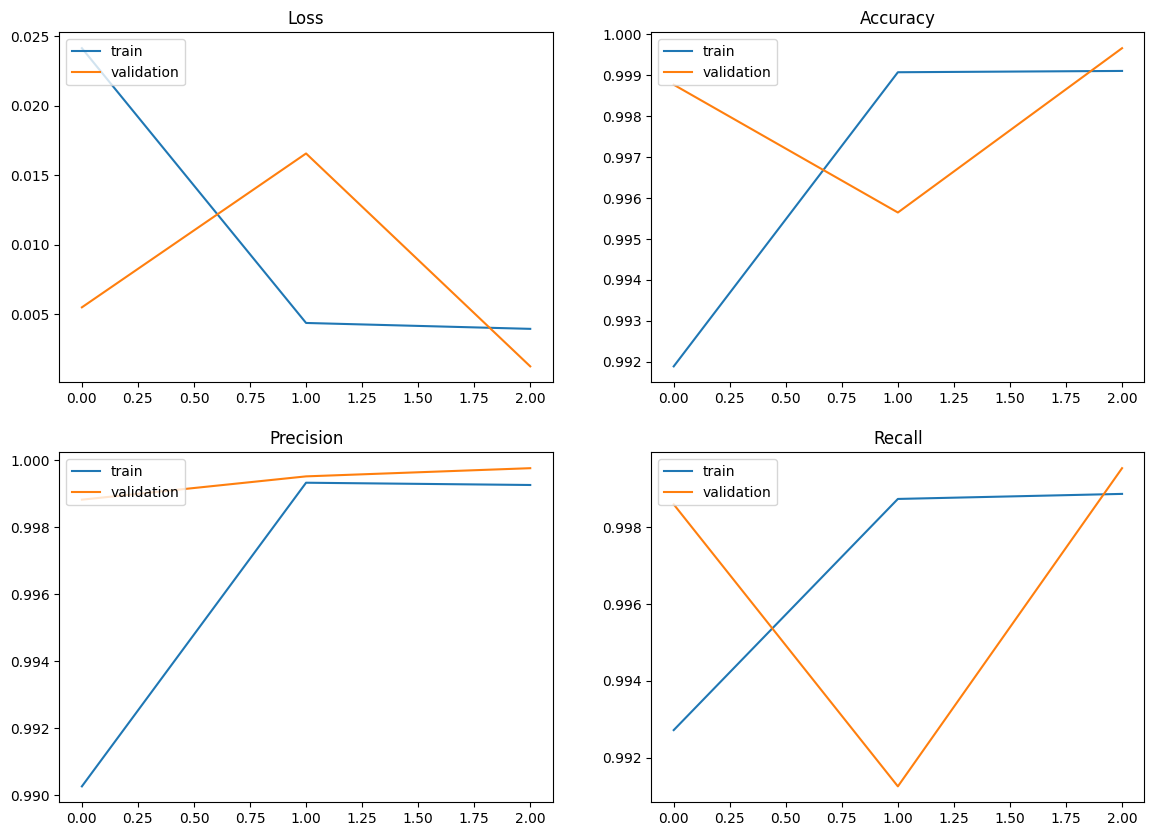

In [29]:
# Training history plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['train', 'validation'], loc='upper left')

axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['train', 'validation'], loc='upper left')

axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['train', 'validation'], loc='upper left')

axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['train', 'validation'], loc='upper left')

plt.show()

In [30]:
# Evaluation on test dataset
model.evaluate(test)

142/142 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9995 - loss: 0.0012 - precision: 1.0000 - recall: 0.9989


[0.0006827230681665242, 0.9997784495353699, 1.0, 0.999515950679779]

# Saving Weights

In [36]:
model.save('model.keras')